In [15]:
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import operator
from tqdm import tqdm

class KNN_Classifier:
    def __init__(self, K=1):
        self.n_neighbor = K
    
    def fit(self, X, Y):
        self.train_data = X
        self.train_labels = Y
    
    def get_distance(self, train_X, test_X):
        total = 0
        for i in range(len(train_X)):
            total = total + np.square(test_X[i]-train_X[i])
        return np.sqrt(total)
    
    def predict_labels(self, test_X):
        test_labels=[]
        for test_d in test_X:
            pred_label = self.predict_label(test_d)
            test_labels.append(pred_label)
        return test_labels
    
    def predict_label(self, test_x):
        distance_map = {}
        for i in range(len(self.train_data)):
            dist = self.get_distance(test_x, self.train_data[i])
            distance_map[i]=dist
            
        sorted_dist = sorted(distance_map.items(), key = operator.itemgetter(1))

        neighbors_list = []
        for i in range(self.n_neighbor):
            neighbors_list.append(sorted_dist[i][0])
        

        majority_vote = {}
        for i in range(len(neighbors_list)):
            label = self.train_labels[neighbors_list[i]]

            if label in majority_vote:
                majority_vote[label]+=1
            else:
                majority_vote[label]=1
        

        sorted_vote = sorted(majority_vote.items(), key=operator.itemgetter(1), reverse=True)
        pred_label = sorted_vote[0][0]
        
        return pred_label
    
def accuracy_score(actual_labels, pred_labels):
    correct = 0
    for i in range(len(actual_labels)):
        if actual_labels[i] == pred_labels[i]:
            correct += 1
    accuracy = correct/len(pred_labels)
    return accuracy

In [16]:
#features = train_df.columns.to_list()[1:]
def forward_selection(train_df, test_df, accuracy_dict):
    features = get_features_list(train_df)
    selected_features = []
    K = 3
    all_best_accuracy = 0.0
    all_best_features = []
    num_features = []  # list to keep track of the number of features
    accuracies = []  # list to keep track of the accuracies
    print("Starting Forward Selection Search")
    prev_acc = 0.0
    for i in tqdm(range(len(features))):
        print("Level ", i+1, " using ", i+1, " features: ")
        best_accuracy = 0.0 
        best_feature = None
        for feature in features:
            if feature not in selected_features:
                current_features = selected_features + [feature]
                current_features = sorted(current_features)
                key = "_".join(map(str, current_features))
                if key not in accuracy_dict:
                    train_X, train_Y, test_X, test_Y = get_train_test_data_for_selected_features(train_df, test_df, current_features)

                    model = KNN_Classifier(K=K)
                    model.fit(train_X, train_Y)
                    predictions = model.predict_labels(test_X)

                    accuracy = accuracy_score(test_Y, predictions)
                    accuracy_dict[key] = accuracy
                else:
                    accuracy = accuracy_dict[key]
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_feature = feature

                print("\tAccuracy: ", accuracy, " after adding ", feature)

        if best_feature is not None:  # Only add feature if one improved the model
            selected_features.append(best_feature)
            features.remove(best_feature)  # Remove the selected feature from the original list
            num_features.append(len(selected_features))  # append the current number of features
            accuracies.append(best_accuracy)  # append the current best accuracy

        if best_accuracy > all_best_accuracy:
            all_best_accuracy = best_accuracy
            all_best_features = selected_features.copy()
            print("Best feature: ", best_feature, " with accuracy: ", best_accuracy)
            print("Feature list: ", selected_features)
        else:
            print("Attention!! Accuracy is decreasing!")
            print("Best feature: ", best_feature, " with accuracy: ", best_accuracy)
            print("Feature list: ", selected_features)
        print()

    all_best_features = sorted(all_best_features)
    print(f'Selected features: {all_best_features}')
    print("Best accuracy: ", all_best_accuracy)
    
    return num_features, accuracies, all_best_features, accuracy_dict
    
def backward_selection(train_df, test_df, accuracy_dict):
    features = get_features_list(train_df)
    selected_features = features  # start with all features
    K = 3
    all_best_accuracy = 0.0
    all_best_features = selected_features.copy()

    # First evaluate the model with all features
    train_X, train_Y, test_X, test_Y = get_train_test_data_for_selected_features(train_df, test_df, selected_features)
    model = KNN_Classifier(K=K)
    model.fit(train_X, train_Y)
    predictions = model.predict_labels(test_X)
    all_best_accuracy = accuracy_score(test_Y, predictions)
    print("Initial accuracy with all features: ", all_best_accuracy)
    
    num_features = []  # list to keep track of the number of features
    accuracies = []  # list to keep track of the accuracies
    print("Starting Backward Selection Search")
    i = len(features)
    while i > 0:
        print("Level ", i, " using ", i, " features: ")
        best_accuracy = 0.0 
        best_feature = None
        for feature in selected_features:
            current_features = selected_features.copy()
            current_features.remove(feature)
            current_features = sorted(current_features)
            key = "_".join(map(str, current_features))
            if key not in accuracy_dict:
                train_X, train_Y, test_X, test_Y = get_train_test_data_for_selected_features(train_df, test_df, current_features)

                model = KNN_Classifier(K=K)
                model.fit(train_X, train_Y)
                predictions = model.predict_labels(test_X)

                accuracy = accuracy_score(test_Y, predictions)
                accuracy_dict[key] = accuracy
            else:
                accuracy = accuracy_dict[key]

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_feature = feature
            
            print("\tAccuracy: ", accuracy, " after removing ", feature)

        if best_feature is not None:  # Only remove feature if it improved the model
            selected_features.remove(best_feature)  # Remove the selected feature from the original list
            num_features.append(len(selected_features))  # append the current number of features
            accuracies.append(best_accuracy)  # append the current best accuracy
            i -= 1

        if best_accuracy >= all_best_accuracy:
            all_best_accuracy = best_accuracy
            all_best_features = selected_features.copy()
            print("Removed feature: ", best_feature, " with accuracy: ", best_accuracy)
            print("Current feature list: ", selected_features)
        else:
            print("Attention!! Accuracy is decreasing!")
            print("Removed feature: ", best_feature, " with accuracy: ", best_accuracy)
            print("Current feature list: ", selected_features)
        print()

    all_best_features = sorted(all_best_features)
    print(f'Selected features: {all_best_features}')
    print("Best accuracy: ", all_best_accuracy)
    
    return num_features, accuracies, all_best_features, accuracy_dict



In [17]:
def load_diabetes_dataset(filename = 'diabetes.csv'):
    data = pd.read_csv(filename)
    
    # Save original column names
    original_columns = data.columns.tolist()

    # Prepare new column names
    new_cols = ['label' if col=='label' else i+1 for i, col in enumerate(data.columns)]

    # Rename columns
    data.columns = new_cols

    # Create a dictionary mapping new column names to old ones
    col_name_mapping = {new: old for new, old in zip(new_cols, original_columns)}

    return data, col_name_mapping

def min_max_scaler(train, test):
    min_val = train.min()
    max_val = train.max()

    train_normalized = (train - min_val) / (max_val - min_val)
    test_normalized = (test - min_val) / (max_val - min_val)

    return train_normalized, test_normalized

def train_test_split(data, test_frac=0.25):
    test_df = data.sample(frac = test_frac, random_state=42)
    train_df = data.drop(test_df.index)

    test_df = test_df.reset_index(drop=True)
    train_df = train_df.reset_index(drop=True)
    
    print("Data size: ", data.shape)
    print("Train size: ", train_df.shape)
    print("Test size: ", test_df.shape)

    train_df, test_df = min_max_scaler(train_df, test_df)
    
    return train_df, test_df

def get_train_test_data_for_selected_features(train_df, test_df, features_to_be_selected):
    
    train_data = train_df[features_to_be_selected].values
    train_labels = train_df['label'].values

    test_data = test_df[features_to_be_selected].values
    test_labels = test_df['label'].values
    
    return train_data, train_labels, test_data, test_labels

def get_features_list(data):
    columns = list(data.columns)
    features = []
    for val in columns:
        if val != 'label':
            features.append(val)
    return features

def plot_feature_count_vs_accuracies(num_features, accuracies, title):
    plt.plot(num_features, accuracies)
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.show()

In [18]:
def load_dataset(file_name="CS170_small_Data__18.txt"):
    if file_name == "diabetes.csv":
        return load_diabetes_dataset()
    # Determine the number of columns in your data file if not known
    with open(file_name, 'r') as f:
        line = f.readline()
        num_cols = len(line.split())

    # Create column names
    col_names = ['label'] + [i+1 for i in range(num_cols - 1)]

    # Load the data
    data = pd.read_csv(file_name, names=col_names, delim_whitespace=True)
    
    if file_name == "CS170_XXXlarge_Data__12.txt":
        print("Sampling 50% of dataset!!")
        data = data.sample(frac=0.5, random_state=42).reset_index(drop=True)

    return data, col_names


In [32]:
# data = load_dataset()
# data.head(3)

In [33]:
model_accuracy_cache = {}

data, col_name_mapping = load_diabetes_dataset()
test_frac=0.25
train_df, test_df = train_test_split(data, test_frac)
print("Data size: ", data.shape)
print("Train size: ", train_df.shape)
print("Test size: ", test_df.shape)

Data size:  (768, 9)
Train size:  (576, 9)
Test size:  (192, 9)
Data size:  (768, 9)
Train size:  (576, 9)
Test size:  (192, 9)


In [34]:
#data.head(3)

In [35]:
features = get_features_list(train_df)
train_X, train_Y, test_X, test_Y = get_train_test_data_for_selected_features(train_df, test_df,features)

model = KNN_Classifier(K=3)
model.fit(train_X, train_Y)
predictions = model.predict_labels(test_X)

accuracy = accuracy_score(test_Y, predictions)
accuracy

0.7083333333333334

In [36]:
# num_features1, accuracies1, all_best_features1, model_accuracy_cache = forward_selection(train_df, test_df, 
#                                                                                       model_accuracy_cache)

In [37]:
# num_features2, accuracies2, all_best_features2, model_accuracy_cache = backward_selection(train_df, test_df, 
#                                                                                        model_accuracy_cache)

In [38]:
# title = 'Forward Selection: Accuracy vs Number of Features'
# plot_feature_count_vs_accuracies(num_features1, accuracies1, title)

# title = 'Backward Selection: Accuracy vs Number of Features'
# plot_feature_count_vs_accuracies(num_features2, accuracies2, title)

In [19]:
def apply_feature_selection(feature_selection, file_name, accuracy_cache):
    data, _ = load_dataset(file_name)
    print(data.shape)
    
    test_frac=0.25
    train_df, test_df = train_test_split(data, test_frac)


    if feature_selection == '1':
        num_features1, accuracies1, \
        all_best_features1, accuracy_cache = forward_selection(train_df,test_df,accuracy_cache)
        title = 'Forward Selection: Accuracy vs Number of Features'
        plot_feature_count_vs_accuracies(num_features1, accuracies1, title)

    elif feature_selection == '2':
        num_features1, accuracies1, \
        all_best_features1, accuracy_cache = backward_selection(train_df,test_df,accuracy_cache)
        title = 'Backward Selection: Accuracy vs Number of Features'
        plot_feature_count_vs_accuracies(num_features1, accuracies1, title)
    return num_features1, accuracies1, all_best_features1, accuracy_cache

In [20]:
import re

def get_accuracy_dict():
    # This will store the accuracy of each feature or set of features.
    accuracy_dict = {}

    # Regular expression pattern to extract the accuracy and feature number.
    pattern = r"Accuracy:\s+(\d\.\d+)\s+after adding\s+(\d+)"

    # Regular expression pattern to extract the current feature list.
    feature_list_pattern = r"Feature list:\s+\[([\d,\s]*)\]"

    # Read the file
    with open('output.txt', 'r') as f:
        lines = f.readlines()

    # List to store features as they're added.
    features = []

    # Parse the file
    for line in lines:
        # Check for a new round
        if "Feature list:" in line:
            match = re.search(feature_list_pattern, line)
            if match:
                # Get the feature list
                features = match.group(1).split(', ')
                # Strip leading/trailing white space and convert to int
                features = [int(feature.strip()) for feature in features]
                # Sort the features
                features.sort()

        else:
            match = re.search(pattern, line)
            if match:
                # Get the accuracy and feature number
                accuracy = float(match.group(1))
                feature = int(match.group(2))

                # Create a key by joining the current feature list with new feature
                temp = features + [feature]
                temp.sort()
                key = '_'.join(map(str, temp))

                # Save to dictionary
                accuracy_dict[key] = accuracy

    # Print the dictionary
    # for k, v in accuracy_dict.items():
    #     print(f"{k}: {v}")
    
    return accuracy_dict


Welcome to Feature Selection Algorithm!


Select the dataset you want to test
	 1 for Small Dataset 
	 2 for Large Dataset 
	 3 for Large Dataset 
	 4 for Diabetes Dataset 4
Select feature selection option 
	 1 for Forward Feature Selection 
	 2 for Backward Feature Selection 1


(768, 9)
Data size:  (768, 9)
Train size:  (576, 9)
Test size:  (192, 9)
Starting Forward Selection Search


  0%|                                                     | 0/8 [00:00<?, ?it/s]

Level  1  using  1  features: 
	Accuracy:  0.5208333333333334  after adding  1
	Accuracy:  0.65625  after adding  2
	Accuracy:  0.515625  after adding  3
	Accuracy:  0.5104166666666666  after adding  4
	Accuracy:  0.5989583333333334  after adding  5
	Accuracy:  0.6458333333333334  after adding  6
	Accuracy:  0.5729166666666666  after adding  7


 12%|█████▋                                       | 1/8 [00:08<01:01,  8.80s/it]

	Accuracy:  0.6302083333333334  after adding  8
Best feature:  2  with accuracy:  0.65625
Feature list:  [2]

Level  2  using  2  features: 
	Accuracy:  0.6770833333333334  after adding  1
	Accuracy:  0.6770833333333334  after adding  3
	Accuracy:  0.6927083333333334  after adding  4
	Accuracy:  0.6145833333333334  after adding  5
	Accuracy:  0.6979166666666666  after adding  6
	Accuracy:  0.71875  after adding  7


 25%|███████████▎                                 | 2/8 [00:19<00:58,  9.76s/it]

	Accuracy:  0.7135416666666666  after adding  8
Best feature:  7  with accuracy:  0.71875
Feature list:  [2, 7]

Level  3  using  3  features: 
	Accuracy:  0.7135416666666666  after adding  1
	Accuracy:  0.7291666666666666  after adding  3
	Accuracy:  0.6927083333333334  after adding  4
	Accuracy:  0.7083333333333334  after adding  5
	Accuracy:  0.71875  after adding  6


 38%|████████████████▉                            | 3/8 [00:30<00:52, 10.54s/it]

	Accuracy:  0.71875  after adding  8
Best feature:  3  with accuracy:  0.7291666666666666
Feature list:  [2, 7, 3]

Level  4  using  4  features: 
	Accuracy:  0.671875  after adding  1
	Accuracy:  0.7083333333333334  after adding  4
	Accuracy:  0.671875  after adding  5
	Accuracy:  0.6875  after adding  6


 50%|██████████████████████▌                      | 4/8 [00:43<00:45, 11.39s/it]

	Accuracy:  0.7239583333333334  after adding  8
Attention!! Accuracy is decreasing!
Best feature:  8  with accuracy:  0.7239583333333334
Feature list:  [2, 7, 3, 8]

Level  5  using  5  features: 
	Accuracy:  0.7239583333333334  after adding  1
	Accuracy:  0.6770833333333334  after adding  4
	Accuracy:  0.6979166666666666  after adding  5


 62%|████████████████████████████▏                | 5/8 [00:54<00:34, 11.35s/it]

	Accuracy:  0.7239583333333334  after adding  6
Attention!! Accuracy is decreasing!
Best feature:  1  with accuracy:  0.7239583333333334
Feature list:  [2, 7, 3, 8, 1]

Level  6  using  6  features: 
	Accuracy:  0.625  after adding  4
	Accuracy:  0.6822916666666666  after adding  5


 75%|█████████████████████████████████▊           | 6/8 [01:04<00:21, 10.80s/it]

	Accuracy:  0.6875  after adding  6
Attention!! Accuracy is decreasing!
Best feature:  6  with accuracy:  0.6875
Feature list:  [2, 7, 3, 8, 1, 6]

Level  7  using  7  features: 
	Accuracy:  0.6822916666666666  after adding  4


 88%|███████████████████████████████████████▍     | 7/8 [01:12<00:09,  9.82s/it]

	Accuracy:  0.75  after adding  5
Best feature:  5  with accuracy:  0.75
Feature list:  [2, 7, 3, 8, 1, 6, 5]

Level  8  using  8  features: 


100%|█████████████████████████████████████████████| 8/8 [01:16<00:00,  9.58s/it]

	Accuracy:  0.7083333333333334  after adding  4
Attention!! Accuracy is decreasing!
Best feature:  4  with accuracy:  0.7083333333333334
Feature list:  [2, 7, 3, 8, 1, 6, 5, 4]

Selected features: [1, 2, 3, 5, 6, 7, 8]
Best accuracy:  0.75


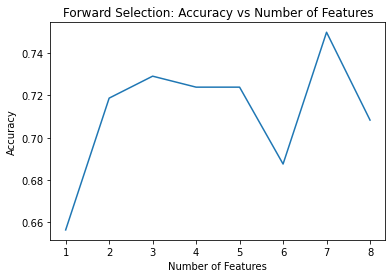

Welcome to Feature Selection Algorithm!


In [ ]:
if __name__ == "__main__":
    small_data_accuracy_cache = {}
    large_data_accuracy_cache = {}
    xlarge_data_accuracy_cache = {} #get_accuracy_dict()
    diabetes_data_accuracy_cache = {}
    while(True):
        print("Welcome to Feature Selection Algorithm!")
        data_selection = input("Select the dataset you want to test\n" + \
                                "\t 1 for Small Dataset \n" + \
                                "\t 2 for Large Dataset \n" + \
                                "\t 3 for Large Dataset \n" + \
                                "\t 4 for Diabetes Dataset")
        
        feature_selection = input("Select feature selection option \n" + \
                                 "\t 1 for Forward Feature Selection \n" + \
                                 "\t 2 for Backward Feature Selection")
        
        if data_selection == '1':
            file_name="CS170_small_Data__18.txt"
            #data = load_dataset(file_name)
            num_features1, accuracies1, all_best_features1, large_data_accuracy_cache = apply_feature_selection(
                feature_selection, file_name, large_data_accuracy_cache)
        
        elif data_selection == '2':
            file_name="CS170_large_Data__31.txt"
            num_features1, accuracies1, all_best_features1, large_data_accuracy_cache = apply_feature_selection(
                feature_selection, file_name, large_data_accuracy_cache)
        
        elif data_selection == '3':
            print(len(xlarge_data_accuracy_cache))
            file_name="CS170_XXXlarge_Data__12.txt"
            num_features1, accuracies1, all_best_features1, xlarge_data_accuracy_cache = apply_feature_selection(
                feature_selection, file_name, xlarge_data_accuracy_cache)
        
        elif data_selection == '4':
            file_name = 'diabetes.csv'
            num_features1, accuracies1, all_best_features1, diabetes_data_accuracy_cache = apply_feature_selection(
                feature_selection, file_name, diabetes_data_accuracy_cache)